In [1]:
!pwd

/global/cfs/cdirs/m4334/jerry/climsim3_dev/online_testing/baseline_models/resLSTM/training


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.image as imag
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os, glob
from tqdm import tqdm
import shutil
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from moviepy.editor import *
import psutil
import time

In [3]:
start_time = time.time()
start_memory = psutil.virtual_memory().used

In [4]:
grid_info = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc')
lon = grid_info['lon'].values
lat = grid_info['lat'].values
lon = ((lon + 180) % 360) - 180
level = grid_info.lev.values
grid_area = grid_info['area']

ds_nn = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/finetune_long/finetune_long_run/run/finetune_long_run.eam.h2.*.nc')
ds_sp = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/mmf_ref/mmf_ref_run/mmf_ref_1230_quick.eam.h2.*.nc')

In [5]:
def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

def plot_online_zonal_bias(var, max_day = 20, save_files = False):
    var_sp = ds_sp[var]
    var_nn = ds_nn[var]
    var_sp_re = np.transpose(var_sp.values, (2,0,1))
    var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
    var_nn_re = np.transpose(var_nn.values, (2,0,1))
    var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)
    
    var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
    var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
    data_sp_trop = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                       coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})
    data_nn_trop = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                       coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})
    bias_trop = data_nn_trop - data_sp_trop

    var_sp_extrop = var_sp_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
    var_nn_extrop = var_nn_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
    data_sp_extrop = xr.DataArray(var_sp_extrop.T, dims=["level", "time"],
                                       coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

    data_nn_extrop = xr.DataArray(var_nn_extrop.T, dims=["level", "time"],
                                       coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

    bias_extrop = data_nn_extrop - data_sp_extrop
    
    if var == 'Q':
        bias_trop = bias_trop * 1e3
        bias_extrop = bias_extrop * 1e3
        vmin = -.75
        vmax = .75
        cmap = 'BrBG'
        var_name = 'Moisture'
        units = '(g/kg)'
    elif var == 'CLDLIQ':
        bias_trop = bias_trop * 1e6
        bias_extrop = bias_extrop * 1e6
        vmin = -20
        vmax = 20
        cmap = 'BrBG'
        var_name = 'Liquid Cloud'
        units = '(mg/kg)'
    elif var == 'T':
        bias_trop = bias_trop
        bias_extrop = bias_extrop
        vmin = -10
        vmax = 10
        cmap = 'RdBu_r'
        var_name = 'Temperature'
        units = '(K)'
    # Prepare the figure and axes
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

    ax = axes[0]
    bias_trop.plot(ax=ax, vmin = vmin, vmax = vmax, cmap = cmap)
    ax.invert_yaxis()
    ax.set_xlim(0, max_day)
    ax.set_title(f'(a) Online Bias NN-MMF within 30S-30N: {var_name} {units}',fontsize=14)
    ax.set_xlabel('Days',fontsize=14)
    ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax = axes[1]
    bias_extrop.plot(ax=ax, vmin = vmin, vmax = vmax, cmap = cmap)
    ax.invert_yaxis()
    ax.set_xlim(0, max_day)
    ax.set_title(f'(b) Online Bias NN-MMF outside 30S-30N: {var_name} {units}',fontsize=14)
    ax.set_xlabel('Days',fontsize=14)
    ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    if save_files:
        plt.savefig(f'{var}_errorgrowth.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return

def plot_maps(var, fps = 8, save_files = False):
    num_hours = ds_nn[var].sizes['time']
    pressure_grid_p1 = np.array(grid_info['P0']*grid_info['hyai'])[np.newaxis,:,np.newaxis]
    pressure_grid_p2 = grid_info['hybi'].values[np.newaxis,:,np.newaxis] * np.ones((1,61,384))*100000
    # state_ps should be used instead of np.ones((1,61,384))*100000
    pressure_grid_val = pressure_grid_p1 + pressure_grid_p2
    dp_val = pressure_grid_val[:,1:61,:] - pressure_grid_val[:,0:60,:]
    pressure_weights = dp_val/np.sum(dp_val, axis = 1)[:, np.newaxis, :]

    nn_weighted = np.sum(ds_nn[var]*pressure_weights, axis = 1)
    sp_weighted = np.sum(ds_sp[var]*pressure_weights, axis = 1)

    var_sp_re = np.transpose(ds_sp[var].values, (2,0,1))
    var_nn_re = np.transpose(ds_nn[var].values, (2,0,1))
    var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
    var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)
    zonal_min_val = float(var_sp_zonal_mean.min())
    zonal_max_val = float(var_sp_zonal_mean.max())
    
    image_files = []
    if os.path.exists(var):
        shutil.rmtree(var)
    os.makedirs(var)
    
    weighted_min_val = float(sp_weighted.min())
    weighted_max_val = float(sp_weighted.max())
    
    for hour in tqdm(range(num_hours)):

        image_file_name = f'{var}/{var}_{str(hour).zfill(5)}.png'
        sp_zonal = xr.DataArray(var_sp_zonal_mean[:,hour,:].T, dims = ['level', 'lat'],
                                        coords={'level': level, 'lat': lats_sorted})
        nn_zonal = xr.DataArray(var_nn_zonal_mean[:,hour,:].T, dims = ['level', 'lat'],
                                        coords={'level': level, 'lat': lats_sorted})

        
        # Create side-by-side figures and axes with Robinson projections
        fig = plt.figure(figsize=(14, 8), constrained_layout=True)  # Adjust figure size as needed
        gs = fig.add_gridspec(2, 2) 
        ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
        ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[1, 1])

        if var == 'Q':
            cmap = 'Blues'
            var_name = 'Moisture'
            units = 'g/kg'
        elif var == 'CLDLIQ':
            cmap = 'BrBG'
            var_name = 'Liquid Cloud'
            units = 'mg/kg'
        elif var == 'T':
            cmap = 'RdBu_r'
            var_name = 'Temperature'
            units = 'K'
            diff_vmin = -5
            diff_vmax = 5
        # Add filled contours to the map

        levels = np.linspace(weighted_min_val, weighted_max_val, 20)
        contour_sp = ax1.tricontourf(
            lon, lat, sp_weighted[hour], 
            transform=ccrs.PlateCarree(),  # Data is in lat-lon coordinates
            cmap=cmap,  # Adjust colormap as needed
            levels=levels,  # Number of contour levels
            extend='both',  # Extend beyond data range
            vmin=weighted_min_val,
            vmax=weighted_max_val
        )
        # Add filled contours to the map
        contour_nn = ax2.tricontourf(
            lon, lat, nn_weighted[hour], 
            transform=ccrs.PlateCarree(),  # Data is in lat-lon coordinates
            cmap=cmap,  # Adjust colormap as needed
            levels=levels,  # Number of contour levels
            extend='both',  # Extend beyond data range
            vmin=weighted_min_val,
            vmax=weighted_max_val
        )

        # Add features like coastlines and borders
        ax1.coastlines(linewidth=0.5, color='black')
        ax2.coastlines(linewidth=0.5, color='black')
        # Add a colorbar
        cbar_sp = plt.colorbar(contour_sp, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8)
        cbar_sp.set_label(f'{units}', fontsize = 14)  # Adjust label to match your data
        cbar_sp.locator = ticker.MaxNLocator(nbins=4)

        cbar_nn = plt.colorbar(contour_nn, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8)
        cbar_nn.set_label(f'{units}', fontsize = 14)  # Adjust label to match your data
        cbar_nn.locator = ticker.MaxNLocator(nbins=4)
        # Set title
        ax1.set_title(f'MMF {var_name}: Hour {hour}', fontsize=18)
        ax1.set_global()

        ax2.set_title(f'Hybrid {var_name}: Hour {hour}', fontsize=18)
        ax2.set_global()

        ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        # Now you can plot your data on ax1 and ax2 as needed

        sp_zonal.plot(ax = ax3,
                      vmin = zonal_min_val,
                      vmax = zonal_max_val,
                      cmap = cmap,
                      cbar_kwargs={
                            'orientation': 'vertical',
                            'pad': 0.00,  # Decrease to move the colorbar closer
                            'shrink': 1
                        })
        nn_zonal.plot(ax = ax4,
                      vmin = zonal_min_val,
                      vmax = zonal_max_val,
                      cmap = cmap,
                      cbar_kwargs={
                            'orientation': 'vertical',
                            'pad': 0.00,  # Decrease to move the colorbar closer
                            'shrink': 1
                        })
    
        
        ax3.set_ylabel('hybrid pressure (hPa)', fontsize = 14)
        ax3.set_xlabel('latitude', fontsize = 14)
        ax4.set_ylabel('hybrid pressure (hPa)', fontsize = 14)
        ax4.set_xlabel('latitude', fontsize = 14)

        
        ax3.tick_params(axis='both', labelsize=14)
        ax4.tick_params(axis='both', labelsize=14)
        
        ax3.invert_yaxis()
        ax4.invert_yaxis()
        
        plt.savefig(image_file_name)
        image_files.append(image_file_name)
        plt.clf()
        plt.close('all')
    video_clip = ImageSequenceClip(sorted(image_files), fps = fps)
    if save_files:
        video_clip.write_videofile(f'{var}.mp4')
    else:
        return video_clip


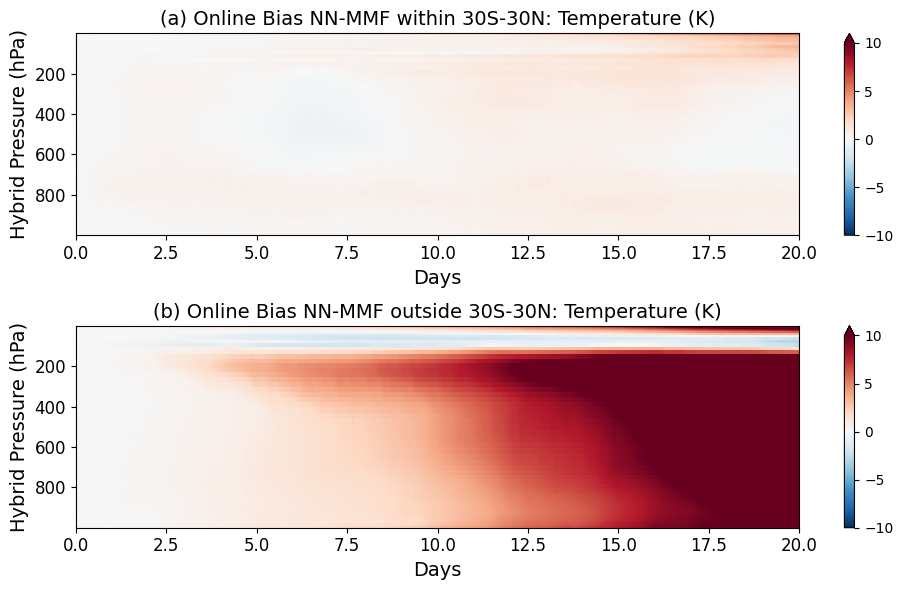

In [6]:
plot_online_zonal_bias('T', save_files = True)

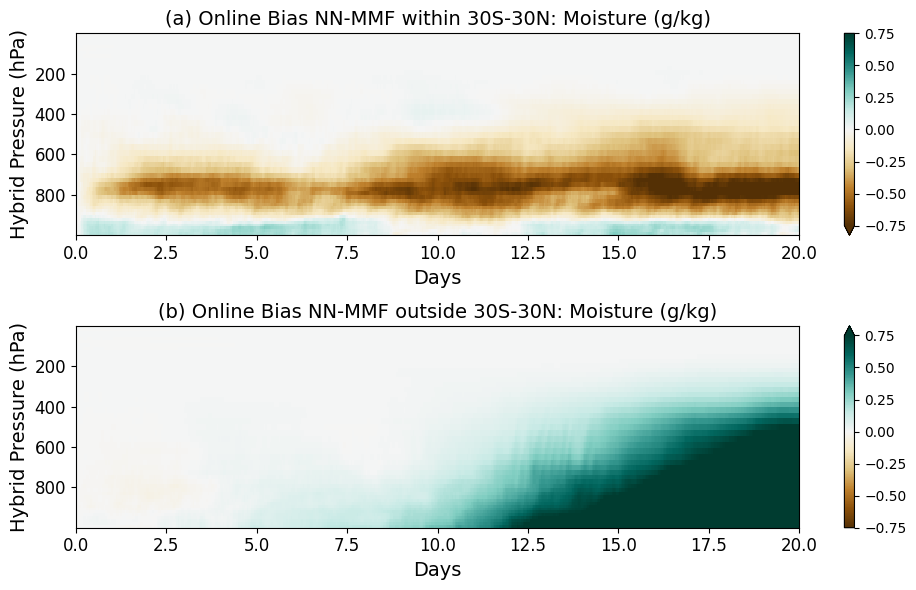

In [7]:
plot_online_zonal_bias('Q', save_files = True)

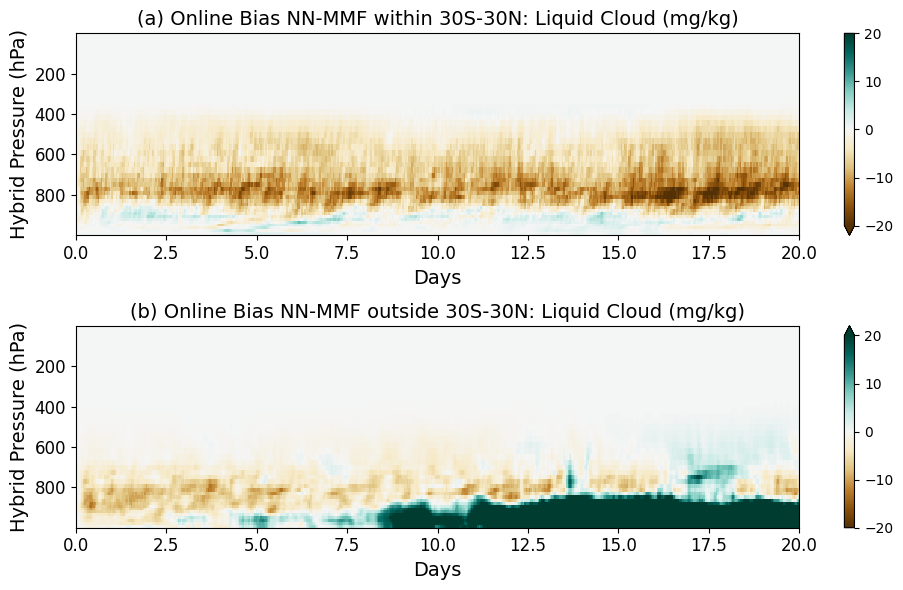

In [8]:
plot_online_zonal_bias('CLDLIQ', save_files = True)

In [9]:
plot_maps('T', save_files = True)

100%|██████████| 688/688 [50:52<00:00,  4.44s/it]


Moviepy - Building video T.mp4.
Moviepy - Writing video T.mp4



Moviepy - Done !
Moviepy - video ready T.mp4


In [10]:
plot_maps('Q', save_files = True)

100%|██████████| 688/688 [51:34<00:00,  4.50s/it]


Moviepy - Building video Q.mp4.
Moviepy - Writing video Q.mp4



Moviepy - Done !
Moviepy - video ready Q.mp4


In [11]:
plot_maps('CLDLIQ', save_files = True)

100%|██████████| 688/688 [52:56<00:00,  4.62s/it]


Moviepy - Building video CLDLIQ.mp4.
Moviepy - Writing video CLDLIQ.mp4



Moviepy - Done !
Moviepy - video ready CLDLIQ.mp4


In [12]:
end_time = time.time()
end_memory = psutil.virtual_memory().used

print(f"Execution time: {end_time - start_time:.2f} seconds")
print(f"Memory usage: {(end_memory - start_memory) / (1024 * 1024):.2f} MB")
print(f"CPU usage: {psutil.cpu_percent()}%")

Execution time: 9688.25 seconds
Memory usage: 3065.93 MB
CPU usage: 0.6%
